# Loan Approval EDA
This notebook consists of all the EDA that was done for the Loan Approval dataset. The final report for this project can be obtained from `final_report.ipynb`.

Here are the descriptions of each feature in the dataset:
* `id (int)` - The unique identifier of each loan.
* `person_age (int)` - The age of the loan applicant (the person applying for a loan).
* `person_income` (int)` - The income of the loan applicant at the time of application.
* `person_home_ownership (str)` - The status of home ownership of the loan application a the time of applicaation.
* `person_emp_length (float)` - The employment length of the loan applicant at the time of application.
* `loan_intent (str)` - The intent of the loan.
* `loan_grade (str)` - The grade of the loan.
* `loan_amnt (int)` - The amount of the loan.
* `loan_int_rate (float)` - The interest rate of the loan - rounded to the nearest 2 decimal points.
* `loan_percent_income (float)` - The percentage of the loan relative to the applicant's income. Calculated as loan_percent_incomet = loan_amnt / person_income. Rounded to the nearest 2 decimal points.
* `cb_person_default_on_file (boolean)` - Whether the applicant has a history of a loan default.
* `cb_person_cred_hist_length (int)` - The credit length history of the applicant (generally the longer the better).
* `loan_status (int)` - Whether the loan was approved or not. This is the target variable.

These descriptions was done by myself after looking at the data. [This](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536984) and [this](https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction/discussion/538233) are other sets of descriptions I found on the Kaggle competition's discussion page.

In [ ]:
import pandas as pd
import numpy as np
import ydata_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [38]:
profile = pp.ProfileReport(df_train)
profile.to_file("ydata_profiles/Loan_Approval_Profiling.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Target Variable

As seen in the profile report, approved loans only make up 14.2% of all loan applications. This leads to a highly imbalanced dataset. This has a potential to affect our model selection and evaluation processes. Therefore, here are a few things to keep in mind:

* Consider balancing the dataset using oversampling techniques such as SMOTE.
* Ensure that evaluation is logical - use metrics such as the balanced accuracy score, F1-score, and ROC-AUC score.
* Investigate false positives as it is a priority to not approve applicants that will end up defaulting.

Here are some other things to keep in mind according to ChatGPT:

1. **Business-Driven Cost Analysis**
- False Negatives (Type II Error): While false positives (approving bad applicants) are a major concern, also consider the cost of false negatives (rejecting good applicants). Too many rejections mean lost revenue for the bank.
- Cost-Benefit Analysis: Assign a cost to each type of misclassification (e.g., approving a bad loan vs. rejecting a good one) to inform decision-making and threshold tuning.

2. **Handling Imbalance Thoughtfully**
- Data-Level Solutions:
  - Use oversampling techniques like SMOTE to generate synthetic minority samples.
  - Try ADASYN, which prioritizes harder-to-classify minority samples.
  - Consider undersampling to remove redundant majority-class samples.
- Algorithm-Level Solutions:
  - Use models that inherently handle class imbalance well, such as XGBoost, LightGBM, and balanced random forests.

3. **Threshold Optimization & Business Constraints**
- Instead of relying on the default 0.5 probability threshold, determine a business-optimal threshold based on precision-recall trade-offs.
- Tune the decision threshold to minimize false positives while maintaining a reasonable true positive rate.
- Consider calibrating predicted probabilities using Platt scaling or isotonic regression to ensure probability outputs align with real-world risks.

4. **Feature Engineering & Explainability**
- Investigate latent patterns in applicant data that might distinguish high-risk borrowers.
- Use SHAP or LIME to interpret model decisions and ensure financial reasoning aligns with business insights.
- Check for potential data leakage to avoid overly optimistic results.

## Numerical Features
The investigation will start by plotting the distributions of all the numerical features. Then, more focused analysis will be done on each feature separately.

In [39]:
numeric_features = df_train.select_dtypes(include=['int','float'])
numeric_features.columns

Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'loan_status'],
      dtype='object')

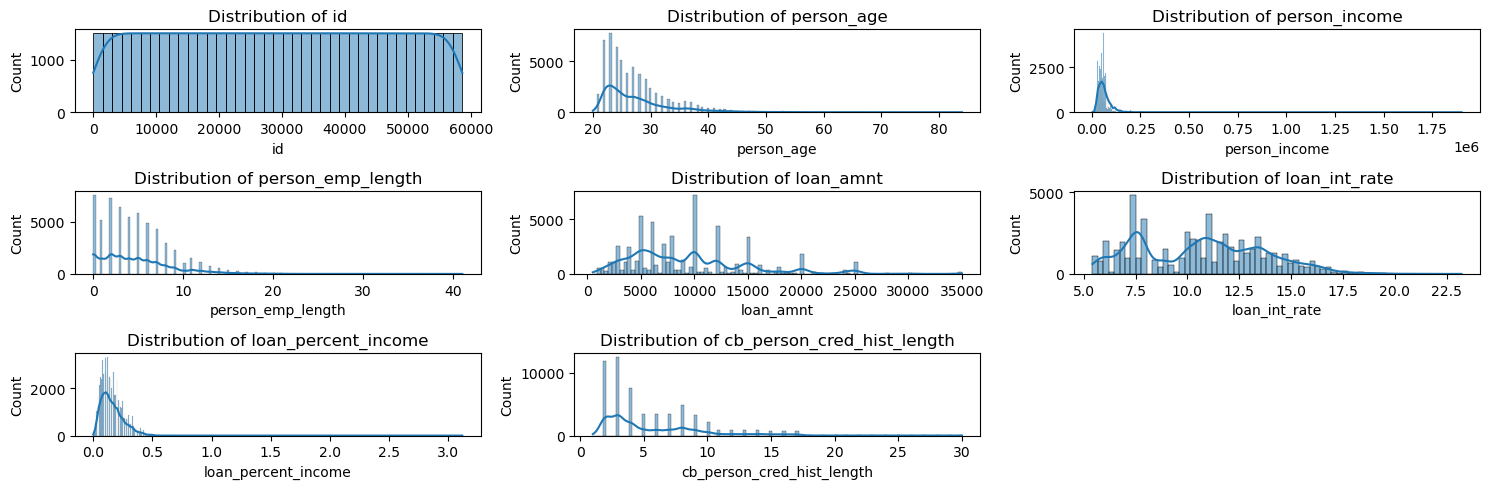

In [ ]:
# Define the number of rows and columns
rows = 3
cols = 3

# Create a figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
axes = axes.flatten()

# Loop through features and plot
for i, feature in enumerate(numeric_features.columns[:8]):
    sns.histplot(data=df_train, x=feature, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

# Remove any empty subplots if there are fewer than 9 features
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Investigate every numerical feature aside from `id` and `loan_status` as the former is unique and uniformly distributed while the latter has been explored in the previous section.

**Note**: Skewness and kurtosis will be investigated in their own sections.

### person_age
In the profile report, it was seen that the max age of a loan applicant is 123 which raises alarm bells. Let's investigate that.

In [40]:
df_train[df_train['person_age']>80]

id  person_age  person_income person_home_ownership  \
4962    4962          84         108928              MORTGAGE   
6750    6750          84          94800              MORTGAGE   
47336  47336         123          36000              MORTGAGE   

       person_emp_length        loan_intent loan_grade  loan_amnt  \
4962                 3.0  DEBTCONSOLIDATION          A       6000   
6750                 2.0           PERSONAL          D      10000   
47336                7.0           PERSONAL          B       6700   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
4962            7.51                 0.06                         N   
6750           14.09                 0.11                         N   
47336          10.75                 0.18                         N   

       cb_person_cred_hist_length  loan_status  
4962                           25            0  
6750                           22            0  
47336                           4            0

As we can see, the second oldest age is 84 which is still sensible compared to the 123 year old. Furthermore, according to [Wikipedia](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people), the oldest verified human in history was 122 years old which means that this 123 year old probably doesn't exist. Instead of dropping the data, I believe that this was a typo and the applicant's actual age is 23. Let's investigate the distribution of the other features for applicants within that age range.

In [41]:
early_20s = df_train[(df_train['person_age']>=20) & (df_train['person_age']<=25)]
pp.ProfileReport(early_20s, minimal=True, html={'minify': True})

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Since the values of the other features for our suspect fits within the range of applicants in their early 20s, I will simply be changing their age from 123 to 23.

In [42]:
df_train.replace({'person_age': {123:23}}, inplace=True)
df_train.iloc[47336]

id                               47336
person_age                          23
person_income                    36000
person_home_ownership         MORTGAGE
person_emp_length                  7.0
loan_intent                   PERSONAL
loan_grade                           B
loan_amnt                         6700
loan_int_rate                    10.75
loan_percent_income               0.18
cb_person_default_on_file            N
cb_person_cred_hist_length           4
loan_status                          0
Name: 47336, dtype: object

### person_income
Nothing seems to be standing out for this feature aside from its skewness and kurtosis which will be investigated later alongside the other features.

### person_emp_length

#### Zeroes
There seems to be a high amount of zeroes for this feature with it making up 12.9% of all values. This would make sense if the person is still young and has not entered the workforce yet. But it is suspicious if they have no employment history and are yet making a loan of income. Lets look at the type of applicants that have 0 employment length.

In [43]:
df_train[df_train['person_emp_length']==0]

id  person_age  person_income person_home_ownership  \
0          0          37          35000                  RENT   
7          7          21          20000                  RENT   
9          9          35         110000              MORTGAGE   
20        20          28          45000                   OWN   
38        38          30          54000                  RENT   
...      ...         ...            ...                   ...   
58607  58607          44          76000                  RENT   
58614  58614          22          75000              MORTGAGE   
58625  58625          23          32004                   OWN   
58635  58635          32          69000                  RENT   
58641  58641          28          28800                  RENT   

       person_emp_length        loan_intent loan_grade  loan_amnt  \
0                    0.0          EDUCATION          B       6000   
7                    0.0           PERSONAL          C       2500   
9                    0.0  DEBTCONSOLIDATION          C      15000   
20                   0.0           PERSONAL          A       3200   
38                   0.0            MEDICAL          B      12500   
...                  ...                ...        ...        ...   
58607                0.0            MEDICAL          C      14000   
58614                0.0            VENTURE          C       5000   
58625                0.0          EDUCATION          A       5000   
58635                0.0  DEBTCONSOLIDATION          B      12000   
58641                0.0            MEDICAL          C      10000   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
0              11.49                 0.17                         N   
7              13.49                 0.13                         Y   
9              12.98                 0.14                         Y   
20              7.88                 0.07                         N   
38             11.71                 0.24                         N   
...              ...                  ...                       ...   
58607          13.16                 0.18                         Y   
58614          13.92                 0.07                         N   
58625           8.00                 0.16                         N   
58635          10.20                 0.17                         N   
58641          12.73                 0.35                         N   

       cb_person_cred_hist_length  loan_status  
0                              14            0  
7                               3            0  
9                               6            0  
20                              5            0  
38                             10            1  
...                           ...          ...  
58607                          13            0  
58614                           3            0  
58625                           4            0  
58635                           7            1  
58641                           8            1  

[7586 rows x 13 columns]

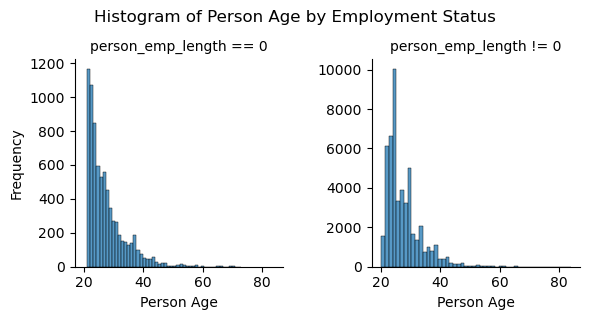

In [44]:
# Filter the data
no_employment = df_train[df_train['person_emp_length'] == 0]['person_age']
employment = df_train[df_train['person_emp_length'] != 0]['person_age']

# Combine the data into a single DataFrame for plotting
combined_data = pd.DataFrame({
    'person_age': pd.concat([no_employment, employment]),
    'employment_status': ['person_emp_length == 0'] * len(no_employment) + ['person_emp_length != 0'] * len(employment)
})

# Plot the histograms side by side using seaborn
g = sns.FacetGrid(combined_data, col='employment_status', sharey=False)
g.map(sns.histplot, 'person_age', bins=50, kde=False)

# Set the axis labels and title
g.set_axis_labels('Person Age', 'Frequency')
g.set_titles('{col_name}')
plt.suptitle('Histogram of Person Age by Employment Status', y=1.05)
plt.show()

**Note**: The y-axis of the two graphs are on different scales! This was done to see the distribution of person_emp_length = 0 more clearly.

As we can see, the distribution between the two seems to be slightly similar.

To confirm this, let's run the Kolmogorov-Smirnov (KS) test two see if the distributions are statistically different. Since the KS test is a [non-parametric test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#One-sample_Kolmogorov%E2%80%93Smirnov_statistic), it is appropriate to apply it here.

Also, let's run a t-test and a levene test to see if there is a statistically significant difference between the mean and variance of the ages of the two groups.

In [45]:
from scipy.stats import ttest_ind, levene, ks_2samp

def perform_test(test_func, group1, group2, test_name):
    """Performs a statistical test and prints results."""
    stat, p_value = test_func(group1, group2, equal_var = False) if test_func == "T-Test" else test_func(group1, group2)
    print(f"{test_name}:\nStatistic = {stat:.4f}, P-value = {p_value:.4f}")

    # Interpretation
    if p_value < 0.05:
        print(f"Result: The {test_name.lower()} indicates a significant difference.\n")
    else:
        print(f"Result: No significant difference found by the {test_name.lower()}.\n")

# Perform tests
perform_test(ttest_ind, no_employment, employment, "T-Test")
perform_test(levene, no_employment, employment, "Levene Test")
perform_test(ks_2samp, no_employment, employment, "Kolmogorov-Smirnov Test")

# Print out mean and variance of both groups
print(f"Employed: \nMean = {employment.mean()}, Variance = {employment.var()}\n")
print(f"Unemployed: \nMean = {no_employment.mean()}, Variance = {no_employment.var()}")



T-Test:
Statistic = 0.8996, P-value = 0.3684
Result: No significant difference found by the t-test.

Levene Test:
Statistic = 7.4998, P-value = 0.0062
Result: The levene test indicates a significant difference.

Kolmogorov-Smirnov Test:
Statistic = 0.0169, P-value = 0.0460
Result: The kolmogorov-smirnov test indicates a significant difference.

Employed: 
Mean = 27.540531541941675, Variance = 35.7763498369296

Unemployed: 
Mean = 27.60717110466649, Variance = 39.39820301804959


This is interesting as the distributions and variances are statistically different while the means of the two groups are not. Taking a step back and understanding why we're investigating these zeroes against the applicants' ages, we are trying to find out whether the features `person_age` and `person_emp_length` are strongly correlated with respect to these zeroes. This is necessary to know when eventually fitting the model and during feature engineering.

For example, we might make a new feature `unemployed` that takes in boolean values dependent on whether `person_emp_length`=0 or not.

I believe that in this specific case, since the sample sizes between the two groups are so different, it would make sense that the distribution and variances are significantly different and that the employed group has a lower variance. Therefore, what is important is the difference in mean between the two groups. Since the difference is not significant, we will leave the zeroes as is.

Comparison against other features could be investigated in the future.

Nevertheless, lets flag individuals who have `person_emp_length`=0 and `person_income`>0 as it is suspicious that you can have no employment and yet make a lot of income. Obviously, there is a chance that these applicants are acquiring passive income from investments, dividends, and other means but it should still be flagged should further investigation be needed.


In [46]:
flag_no_emp_high_income = df_train[(df_train['person_emp_length']==0) & (df_train['person_income']>0)].index

#### Outliers
There seems to be a set of outliers in the data.

In [47]:
df_train.sort_values(by='person_emp_length', ascending=False).head()

id  person_age  person_income person_home_ownership  \
49252  49252          21         192000              MORTGAGE   
41079  41079          28          60350              MORTGAGE   
26125  26125          43          56000                  RENT   
9997    9997          58          48000                  RENT   
50559  50559          56          70000                  RENT   

       person_emp_length      loan_intent loan_grade  loan_amnt  \
49252              123.0          VENTURE          B      20000   
41079              123.0          MEDICAL          D      25000   
26125               41.0  HOMEIMPROVEMENT          B       2000   
9997                41.0         PERSONAL          D       7500   
50559               39.0          MEDICAL          B       8000   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
49252          11.49                 0.10                         N   
41079          15.95                 0.35                         Y   
26125          10.99                 0.04                         N   
9997           13.55                 0.17                         Y   
50559          11.36                 0.11                         N   

       cb_person_cred_hist_length  loan_status  
49252                           2            0  
41079                           6            1  
26125                          14            0  
9997                           24            0  
50559                          17            0

Unlike the problem with `person_age`, I can't justify this as a typo since even if the actual employment length is 23 (or even 12), that means that the applicants has started working since they were -2 and 5 years old (or 11 and 16 years old if the length is 12) respectively which does not make sense. Therefore, we will be removing these two records from our dataset.

In [48]:
df_train.drop([49252, 41079], axis=0, inplace=True)

In terms of generalizing this rule for `df_test` however, we will be subtracting 100 years from `person_emp_length` if the value is more than 100. We will then flag for child/impossible labor as specified below if needed.

#### Flagging child labor (or impossible labor)
Define:
* child labor: anyone who was working before they were 14 years old
* impossible labor: anyone are working longer than their age

Relating to the previous sub-section, lets investigate applicants who seem to have been working from too young of an age. We will use 14 as the minimum working age in accordance to [Ontario](https://www.ontario.ca/page/minimum-age-work) and [Quebec](https://www.cnesst.gouv.qc.ca/en/working-conditions/special-status/young-workers/young-people-under-14-years-age#:~:text=In%20Quebec%2C%20the%20minimum%20legal,be%20obtained%20by%20their%20employer.) laws.

In [49]:
df_train['age_of_first_emp'] = df_train['person_age'] - df_train['person_emp_length']
df_train[df_train['age_of_first_emp'] < 14].head()

id  person_age  person_income person_home_ownership  \
699      699          30          76500              MORTGAGE   
746      746          23         100000              MORTGAGE   
3072    3072          24          72000                  RENT   
8222    8222          26          64999              MORTGAGE   
12638  12638          32          61000              MORTGAGE   

       person_emp_length      loan_intent loan_grade  loan_amnt  \
699                 19.0          MEDICAL          A      14750   
746                 17.0         PERSONAL          A      17000   
3072                12.0  HOMEIMPROVEMENT          B      14000   
8222                13.0        EDUCATION          B      12000   
12638               21.0          VENTURE          B      12000   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
699             6.62                 0.20                         N   
746             7.49                 0.17                         N   
3072           12.69                 0.19                         N   
8222           10.99                 0.17                         N   
12638          11.49                 0.20                         N   

       cb_person_cred_hist_length  loan_status  age_of_first_emp  
699                             8            0              11.0  
746                             3            0               6.0  
3072                            2            0              12.0  
8222                            3            0              13.0  
12638                           6            0              11.0

In [50]:
df_train[df_train['age_of_first_emp'] < 14].shape

(26, 14)

There are 26 applicants who started working below the minimum age allowed to work in Canada. There are two options on how to deal with these applicants:
1) Drop them from the dataset
2) Reduce their `person_emp_length` such that their `age_of_first_emp` is at least 14 years old.

I will be doing Option 2 because other than this discrepancy, every other feature for these applicants seems to be valid. Furthermore, since the dataset was [synthetically generated](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536990) from this [DataCamp presentation](https://projector-video-pdf-converter.datacamp.com/19197/chapter1.pdf), I believe that I have the liberty of assigning these applicants to be from Canada and therefore use the minimum age of labor from Canada.

**Note**: Let's just flag these 26 applicants just in case.

In [51]:
flag_min_emp_age_violation = df_train[df_train['age_of_first_emp'] < 14].index

In [52]:
diff = 14 - df_train[df_train['age_of_first_emp'] < 14]['age_of_first_emp']  # Find difference
df_train.loc[diff.index, 'person_emp_length'] = df_train.loc[diff.index, 'person_emp_length'] - diff  # Subtract diff from person_emp_length
df_train['age_of_first_emp'] = df_train['person_age'] - df_train['person_emp_length']  # Recalculate age_of_first_emp
df_train.loc[diff.index][['person_age','person_emp_length','age_of_first_emp']]  # Expect this to be empty

person_age  person_emp_length  age_of_first_emp
699            30               16.0              14.0
746            23                9.0              14.0
3072           24               10.0              14.0
8222           26               12.0              14.0
12638          32               18.0              14.0
15921          27               13.0              14.0
16378          36               22.0              14.0
17542          38               24.0              14.0
17861          33               19.0              14.0
18293          23                9.0              14.0
18783          22                8.0              14.0
20615          21                7.0              14.0
24214          43               29.0              14.0
26125          43               29.0              14.0
32236          23                9.0              14.0
33012          24               10.0              14.0
34852          36               22.0              14.0
41912          23                9.0              14.0
43518          25               11.0              14.0
48118          33               19.0              14.0
48185          23                9.0              14.0
48915          22                8.0              14.0
52038          38               24.0              14.0
53992          23                9.0              14.0
56176          37               23.0              14.0
58602          23                9.0              14.0

Now we've ensured that every applicant started working at a legal age!

### loan_amnt & loan_percent_income
In the profile report, `loan_amnt` does not seem to raise any flags aside from its high correlation with `loan_percent_income`. For `loan_percent_income`, lets verify whether the percentages make sense (i.e. `loan_percent_income` = `loan_amnt` / `person_income`). There seems to be 2 zero values as well in `loan_percent_income` while there are no zero values for `person_income` so lets investigate that as well.

#### Potential inconsistencies

In [53]:
custom_loan_percent_income = round(df_train['loan_amnt'] / df_train['person_income'], 2)

# Find inconsistencies
compare = df_train['loan_percent_income'].compare(custom_loan_percent_income)
compare.rename(columns={"self": "custom", "other": "original"}, inplace=True)
compare['custom rate > original rate'] = compare['custom'] > compare['original']
compare

custom  original  custom rate > original rate
7        0.13      0.12                         True
10       0.17      0.16                         True
15       0.23      0.22                         True
32       0.07      0.08                        False
37       0.25      0.23                         True
...       ...       ...                          ...
58547    0.22      0.21                         True
58561    0.39      0.38                         True
58609    0.34      0.33                         True
58619    0.18      0.19                        False
58638    0.05      0.06                        False

[6325 rows x 3 columns]

In [54]:
# Count how many are true
compare['custom rate > original rate'].value_counts()

custom rate > original rate
True     3185
False    3140
Name: count, dtype: int64

There seems to be some inconsistencies in the `loan_percent_income` feature. Perhaps this is simply a rounding error but there are some values that are off by 0.02 which indicates otherwise. Lets look at the distribution of the applicants that have these inconsistencies to see if there's a pattern to the calculation inconsistencies.

In [55]:
inconsistent_loan_pct_df = df_train.iloc[
    df_train['loan_percent_income']
    .compare(custom_loan_percent_income)
    .index
].copy()
consistent_loan_pct_df = df_train.drop(index = inconsistent_loan_pct_df.index)

inconsistent_profile = pp.ProfileReport(inconsistent_loan_pct_df)
consistent_profile = pp.ProfileReport(consistent_loan_pct_df)

inconsistent_profile.to_file("ydata_profiles/Inconsistent_Loan_Percentage_Profile.html")
consistent_profile.to_file("ydata_profiles/Consistent_Loan_Percentage_Profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
for feature in numeric_features:
    print(feature)
    perform_test(
        ttest_ind,
        consistent_loan_pct_df[feature],
        inconsistent_loan_pct_df[feature],
        test_name="T-Test"
    )
    print()

id
T-Test:
Statistic = 0.3002, P-value = 0.7640
Result: No significant difference found by the t-test.


person_age
T-Test:
Statistic = -0.8335, P-value = 0.4046
Result: No significant difference found by the t-test.


person_income
T-Test:
Statistic = 0.5884, P-value = 0.5562
Result: No significant difference found by the t-test.


person_emp_length
T-Test:
Statistic = -1.0980, P-value = 0.2722
Result: No significant difference found by the t-test.


loan_amnt
T-Test:
Statistic = -21.3884, P-value = 0.0000
Result: The t-test indicates a significant difference.


loan_int_rate
T-Test:
Statistic = -12.5153, P-value = 0.0000
Result: The t-test indicates a significant difference.


loan_percent_income
T-Test:
Statistic = -26.7101, P-value = 0.0000
Result: The t-test indicates a significant difference.


cb_person_cred_hist_length
T-Test:
Statistic = 0.0896, P-value = 0.9286
Result: No significant difference found by the t-test.


loan_status
T-Test:
Statistic = -24.7969, P-value = 0.0000


We can see that there is a significant difference in means for the features: `loan_amnt`, `loan_int_rate`, `loan_percent_income`, and `loan_status`. Lets look at the means and variances of the features between the two groups.

In [57]:
for feature in ["loan_amnt", "loan_int_rate", "loan_percent_income", "loan_status"]:
    print(feature)
    print(
        f"consistent mean = {consistent_loan_pct_df[feature].mean():.2f}, "
        f"consistent variance = {consistent_loan_pct_df[feature].var():.2f}"
      )
    print(
        f"inconsistent mean = {inconsistent_loan_pct_df[feature].mean():.2f}, "
        f"inconsistent variance = {inconsistent_loan_pct_df[feature].var():.2f}\n"
      )

loan_amnt
consistent mean = 9046.92, consistent variance = 29681808.09
inconsistent mean = 10624.83, inconsistent variance = 39231955.65

loan_int_rate
consistent mean = 10.62, consistent variance = 9.02
inconsistent mean = 11.13, inconsistent variance = 10.56

loan_percent_income
consistent mean = 0.16, consistent variance = 0.01
inconsistent mean = 0.19, inconsistent variance = 0.01

loan_status
consistent mean = 0.13, consistent variance = 0.11
inconsistent mean = 0.24, inconsistent variance = 0.18



We observe that the means for the inconsistent group are generally higher than those of the consistent group. This suggests that when there is a discrepancy in the `loan_percent_income` calculation, the applicant tends to request a higher `loan_amnt` and a higher `loan_int_rate`.

Initially, I hypothesized that discrepancies would be associated with higher loan amounts and lower interest rates, potentially indicating fraudulent activity. However, since both `loan_amnt` and `loan_int_rate` are higher, this pattern does not directly support that assumption. Further investigation is required to determine the root cause of these discrepancies.

More concerning is the fact that loan approvals for the inconsistent group occur almost twice as frequently compared to the consistent group. This aligns with my initial suspicion and warrants a deeper analysis to understand whether these discrepancies could be exploited or indicative of systematic issues in the approval process.

For now, I believe fixing the inconsistencies should be sufficient.

In [58]:
# Fixing inconsistencies
df_train['loan_percent_income'] = round(df_train['loan_amnt'] / df_train['person_income'], 2)

And let's just flag these violaters should further investigation be needed:

In [59]:
flag_inconsistent_loan_percentage = inconsistent_loan_pct_df.index

#### Zeroes

In [60]:
df_train[df_train['loan_percent_income']==0]

id  person_age  person_income person_home_ownership  \
11422  11422          29         948000                   OWN   
12404  12404          25        1839784                  RENT   
12610  12610          30         510000              MORTGAGE   
17387  17387          22        1900000              MORTGAGE   
20222  20222          36         280000              MORTGAGE   
25959  25959          25         889000              MORTGAGE   
34752  34752          27         928000              MORTGAGE   
37591  37591          29        1824000              MORTGAGE   
37902  37902          35         900000              MORTGAGE   
42939  42939          26         700000              MORTGAGE   

       person_emp_length        loan_intent loan_grade  loan_amnt  \
11422               11.0           PERSONAL          B       4000   
12404                0.0            VENTURE          A       8000   
12610                2.0           PERSONAL          B       1800   
17387                6.0          EDUCATION          D       1500   
20222                2.0            VENTURE          C       1000   
25959                9.0          EDUCATION          B       4000   
34752                8.0            VENTURE          C       2850   
37591                8.0  DEBTCONSOLIDATION          C       6000   
37902               18.0           PERSONAL          B       4500   
42939               10.0          EDUCATION          B       2000   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
11422          11.83                  0.0                         N   
12404           8.00                  0.0                         N   
12610           9.01                  0.0                         N   
17387          15.62                  0.0                         Y   
20222          15.96                  0.0                         N   
25959          11.49                  0.0                         N   
34752          13.92                  0.0                         N   
37591          13.99                  0.0                         N   
37902          10.65                  0.0                         N   
42939          12.69                  0.0                         N   

       cb_person_cred_hist_length  loan_status  age_of_first_emp  
11422                           5            0              18.0  
12404                           3            0              25.0  
12610                           9            0              28.0  
17387                           3            0              16.0  
20222                          17            0              34.0  
25959                           3            0              16.0  
34752                           7            0              19.0  
37591                           6            0              21.0  
37902                           6            0              17.0  
42939                           4            0              16.0

Looking at this, applicants who have a 0 `loan_percent_income` are applicants who have a `person_income` of more than 200,000 and the `loan_amnt` of less than 10,000. This leads to the zeroes in `loan_percent_income`. Therefore, we will leave it as is.

### cb_person_credit_hist_length
The profile report states that this feature is highly correlated with the feature `person_age` which makes sense since the older an applicant is, the longer their credit_history length ideally. Lets see this visually:

                            person_age  cb_person_cred_hist_length
person_age                    1.000000                    0.876253
cb_person_cred_hist_length    0.876253                    1.000000


<Axes: xlabel='person_age', ylabel='cb_person_cred_hist_length'>

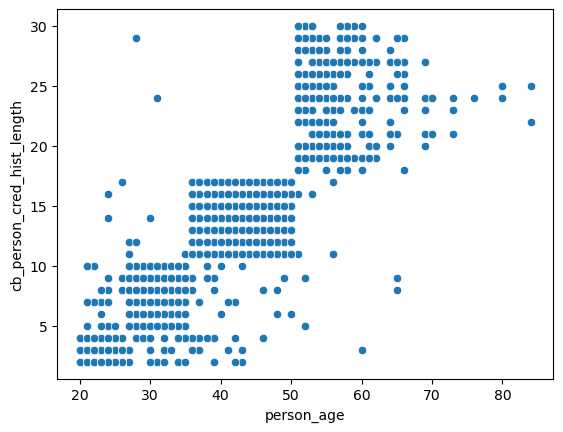

In [61]:
print(df_train[['person_age','cb_person_cred_hist_length']].corr())
sns.scatterplot(df_train, x='person_age', y='cb_person_cred_hist_length')

This aligns with our intuition. Highly correlated features can severly affect model performance so this is something to keep in mind during feature engineering and model selection. For now, lets investigate if there are any values for credit history that do not make sense. More specifically, if there are any applicants who has a longer credit history than their age.

In [62]:
df_train[df_train['person_age']<df_train['cb_person_cred_hist_length']]

id  person_age  person_income person_home_ownership  \
21827  21827          28         186480              MORTGAGE   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
21827                2.0    PERSONAL          A      10000           5.42   

       loan_percent_income cb_person_default_on_file  \
21827                 0.05                         N   

       cb_person_cred_hist_length  loan_status  age_of_first_emp  
21827                          29            0              26.0

This applicant's value does not make sense since their credit history length is longer than their age. We could drop this applicant from the dataset or change their `cb_person_cred_hist_length` to only be as long as the number of years since the applicant can legally apply for a credit history. In fact, this then begs the question if there is anyone else in the dataset who has their `cb_person_cred_hist_length` to indicate that they acquired their credit history prior to the legal age.

If we assume that this dataset is from Canada, then the earliest age a person could get a credit history is 18 which is the legal age in some provinces in Canada (others being 19) according to [Equifax](https://www.equifax.ca/personal/education/credit-report/articles/-/learn/getting-a-credit-card-young-adults/#:~:text=If%20you're%20in%20college,reported%20is%20accurate%20and%20complete.) and [AMEX](https://www.americanexpress.com/ca/en/articles/life-with-amex/learn/how-to-get-credit-card-canada/#:~:text=At%20what%20age%20can%20I,18%20or%2019%20in%20Canada.). In this case, let's investigate potential violaters (i.e. applicants who created a credit card before they turn legal).

In [63]:
df_train['years_from_19'] = df_train['person_age'] - 19
credit_history_violaters_df = df_train[df_train['years_from_19'] < df_train['cb_person_cred_hist_length']]
credit_history_violaters_df

id  person_age  person_income person_home_ownership  \
7          7          21          20000                  RENT   
18        18          22          84000              MORTGAGE   
21        21          22          45000              MORTGAGE   
24        24          22          30000                  RENT   
27        27          21          45000                  RENT   
...      ...         ...            ...                   ...   
58611  58611          21          24000                  RENT   
58619  58619          22          37000                  RENT   
58620  58620          21          18000                  RENT   
58624  58624          22          36000                  RENT   
58639  58639          22          70000                  RENT   

       person_emp_length        loan_intent loan_grade  loan_amnt  \
7                    0.0           PERSONAL          C       2500   
18                   6.0  DEBTCONSOLIDATION          B       5950   
21                   3.0           PERSONAL          A       7000   
24                   3.0            MEDICAL          D       5000   
27                   5.0  DEBTCONSOLIDATION          A       2800   
...                  ...                ...        ...        ...   
58611                5.0            MEDICAL          C      10000   
58619                6.0          EDUCATION          C       7000   
58620                2.0            VENTURE          B       2400   
58624                5.0            VENTURE          E      16000   
58639                6.0  DEBTCONSOLIDATION          A      10000   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
7              13.49                 0.12                         Y   
18             11.12                 0.07                         N   
21              8.59                 0.16                         N   
24             16.49                 0.17                         N   
27              6.54                 0.06                         N   
...              ...                  ...                       ...   
58611          13.85                 0.42                         N   
58619          13.49                 0.19                         Y   
58620          11.46                 0.13                         N   
58624          16.45                 0.44                         N   
58639           7.29                 0.14                         N   

       cb_person_cred_hist_length  loan_status  age_of_first_emp  \
7                               3            0              21.0   
18                              4            0              16.0   
21                              4            0              19.0   
24                              4            1              19.0   
27                              4            0              16.0   
...                           ...          ...               ...   
58611                           4            1              16.0   
58619                           4            0              16.0   
58620                           4            0              19.0   
58624                           4            1              17.0   
58639                           4            0              16.0   

       years_from_19  
7                  2  
18                 3  
21                 3  
24                 3  
27                 2  
...              ...  
58611              2  
58619              3  
58620              2  
58624              3  
58639              3  

[5549 rows x 15 columns]

Since we're operating under the assumption that this dataset is from Canada (even though it's not since it's synthetically generated), lets clean the data so that the `cb_person_credit_hist_length` is only as long as `person_age` minus 19.

In [64]:
diff = df_train[df_train['years_from_19'] < df_train['cb_person_cred_hist_length']]  # Calculate diff
df_train.loc[diff.index, 'cb_person_cred_hist_length'] = df_train.loc[diff.index, 'years_from_19']  # Reassign
df_train[df_train['years_from_19'] < df_train['cb_person_cred_hist_length']]  # Expect this to be empty

Empty DataFrame
Columns: [id, person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length, loan_status, age_of_first_emp, years_from_19]
Index: []

Just to see how the correlation has changed after we fixed the credit history length, let's print the correlation amounts and the scatterplot once again.

                            person_age  cb_person_cred_hist_length
person_age                    1.000000                    0.893707
cb_person_cred_hist_length    0.893707                    1.000000


<Axes: xlabel='person_age', ylabel='cb_person_cred_hist_length'>

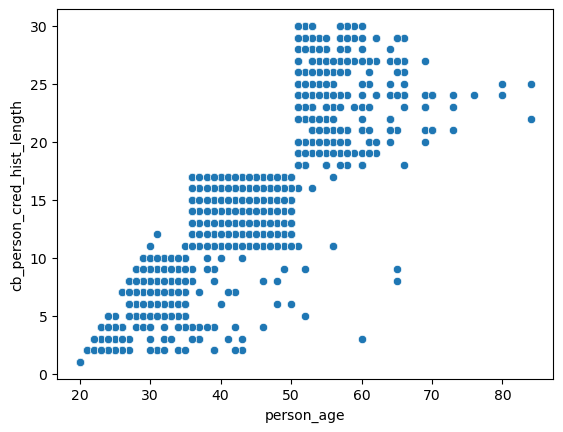

In [65]:
print(df_train[['person_age','cb_person_cred_hist_length']].corr())
sns.scatterplot(df_train, x='person_age', y='cb_person_cred_hist_length')

As expected, the correlation has increased. Just like with the other features who are highly correlated, we should keep this relationship in mind during feature engineering and model selection.

And finally, let's flag the violaters so that their record is available for further investigation if needed:

In [66]:
flag_credit_history_violation = credit_history_violaters_df.index

### loan_int_rate
The profile report indicates that `loan_int_rate` is highly correlated with the features `loan_grade` and `cb_person_default_on_file`. This intuitively makes sense as one would assume that the lower the interest rate, the better the grade (towards 'A'). Also, in terms of defaulting, the higher the interest rate, the higher the probability that the applicant defaults since it would harder to pay back. Let's see the distribution of `loan_int_rate` with respect to the categories in `loan_grade` and `cb_person_default_on_file` to verify these assumptions.

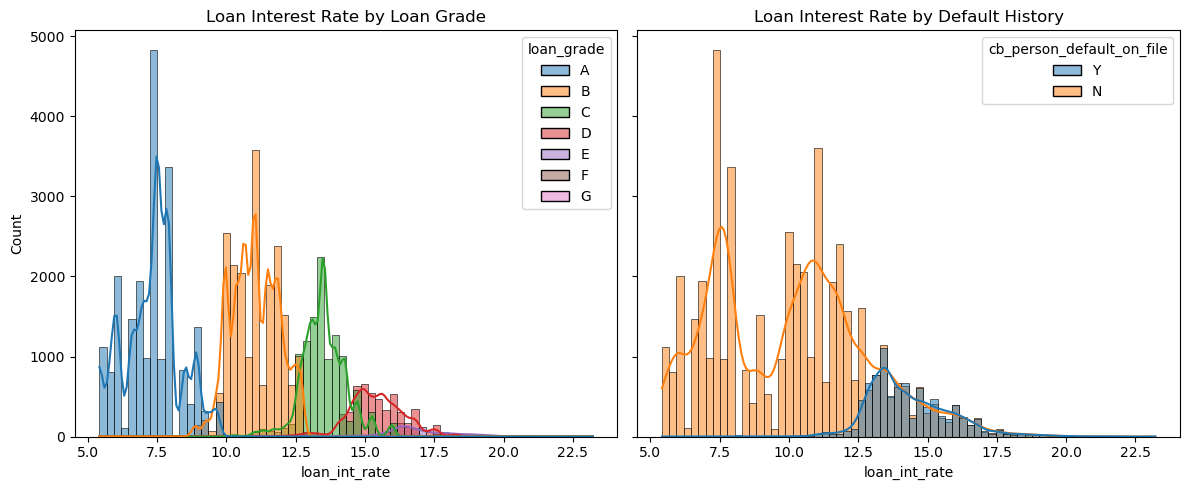

In [67]:
# Define the custom legend order
loan_grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
default_order = ['Y', 'N']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot first histogram with custom hue order
sns.histplot(df_train, x='loan_int_rate', hue='loan_grade', hue_order=loan_grade_order, ax=axes[0], kde=True)
axes[0].set_title("Loan Interest Rate by Loan Grade")

# Plot second histogram with custom hue order
sns.histplot(df_train, x='loan_int_rate', hue='cb_person_default_on_file', hue_order=default_order, ax=axes[1], kde=True)
axes[1].set_title("Loan Interest Rate by Default History")

# Adjust layout
plt.tight_layout()
plt.show()

As seen in the graphs above, there is a strong correlation between `loan_int_rate` and `loan_grade` and `cb_person_default_on_file` respectively as suspected. Since there is a such a strong correlation, we might have to drop either `loan_int_rate` or the other two since some models do not handle multicollineraity well. Conversely, we could just keep everything and use a tree-based model since tree models handle redundancy fairly better. Therefore, this is simply something to keep in mind during feature engineering and model building in the future. On that note, the same awareness must be applied to other highly correlated features such as `loan_percent_income` since it was constructed using two other features in the data.

## Conclusion for Numerical Features EDA
Based on our exploratory data analysis, the following corrections need to be applied to df_test to ensure data consistency and accuracy:

* Correcting Age and Employment Length Outliers:
    * If person_age > 100, subtract 100 years from the value (e.g., 123 → 23).
    * If person_emp_length > 100, subtract 100 years from the value (e.g., 123 → 23).

* Ensuring Logical Age and Employment Length Relationship:
    * If person_age - person_emp_length < 14, adjust person_emp_length so that the expression satisfies (≥ 14). This ensures employment length is reasonable relative to the applicant's age.

* Fixing Inconsistencies in `loan_percent_income`:
    * Ensure that loan_percent_income = loan_amnt / person_income. This correction applies to all cases, including instances where loan_percent_income = 0.

* Correcting Credit History Length Anomalies:
    * If cb_person_cred_hist_length > person_age - 19, adjust cb_person_cred_hist_length so that it equals person_age - 19. This ensures that the reported credit history length is realistic given the applicant’s age.

* Flagging Potential Fraudulent Activities:
    * Flag indexes that have no employment history (`person_emp_length` = 0) but a positive income value (`person_income` > 0).
    * Flag indexes that had an inconsistency in their loan percentage of income ((`loan_amnt` / `person_income`) != `loam_percentage_income`).
    * Flag indexes that had started working earlier than 14 years old (`person_emp_length` - `person_age` <> 14).
    * Flag indexes that had created their credit history earlier than 18 years old (`cb_person_cred_hist_length` > `person_age` - 19).

## Categorical Features
For categorical features, a focus on interpretation would be applied similar to how the numerical features was explored.

In [68]:
cat_features = df_train.select_dtypes(include=['object'])
cat_features.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

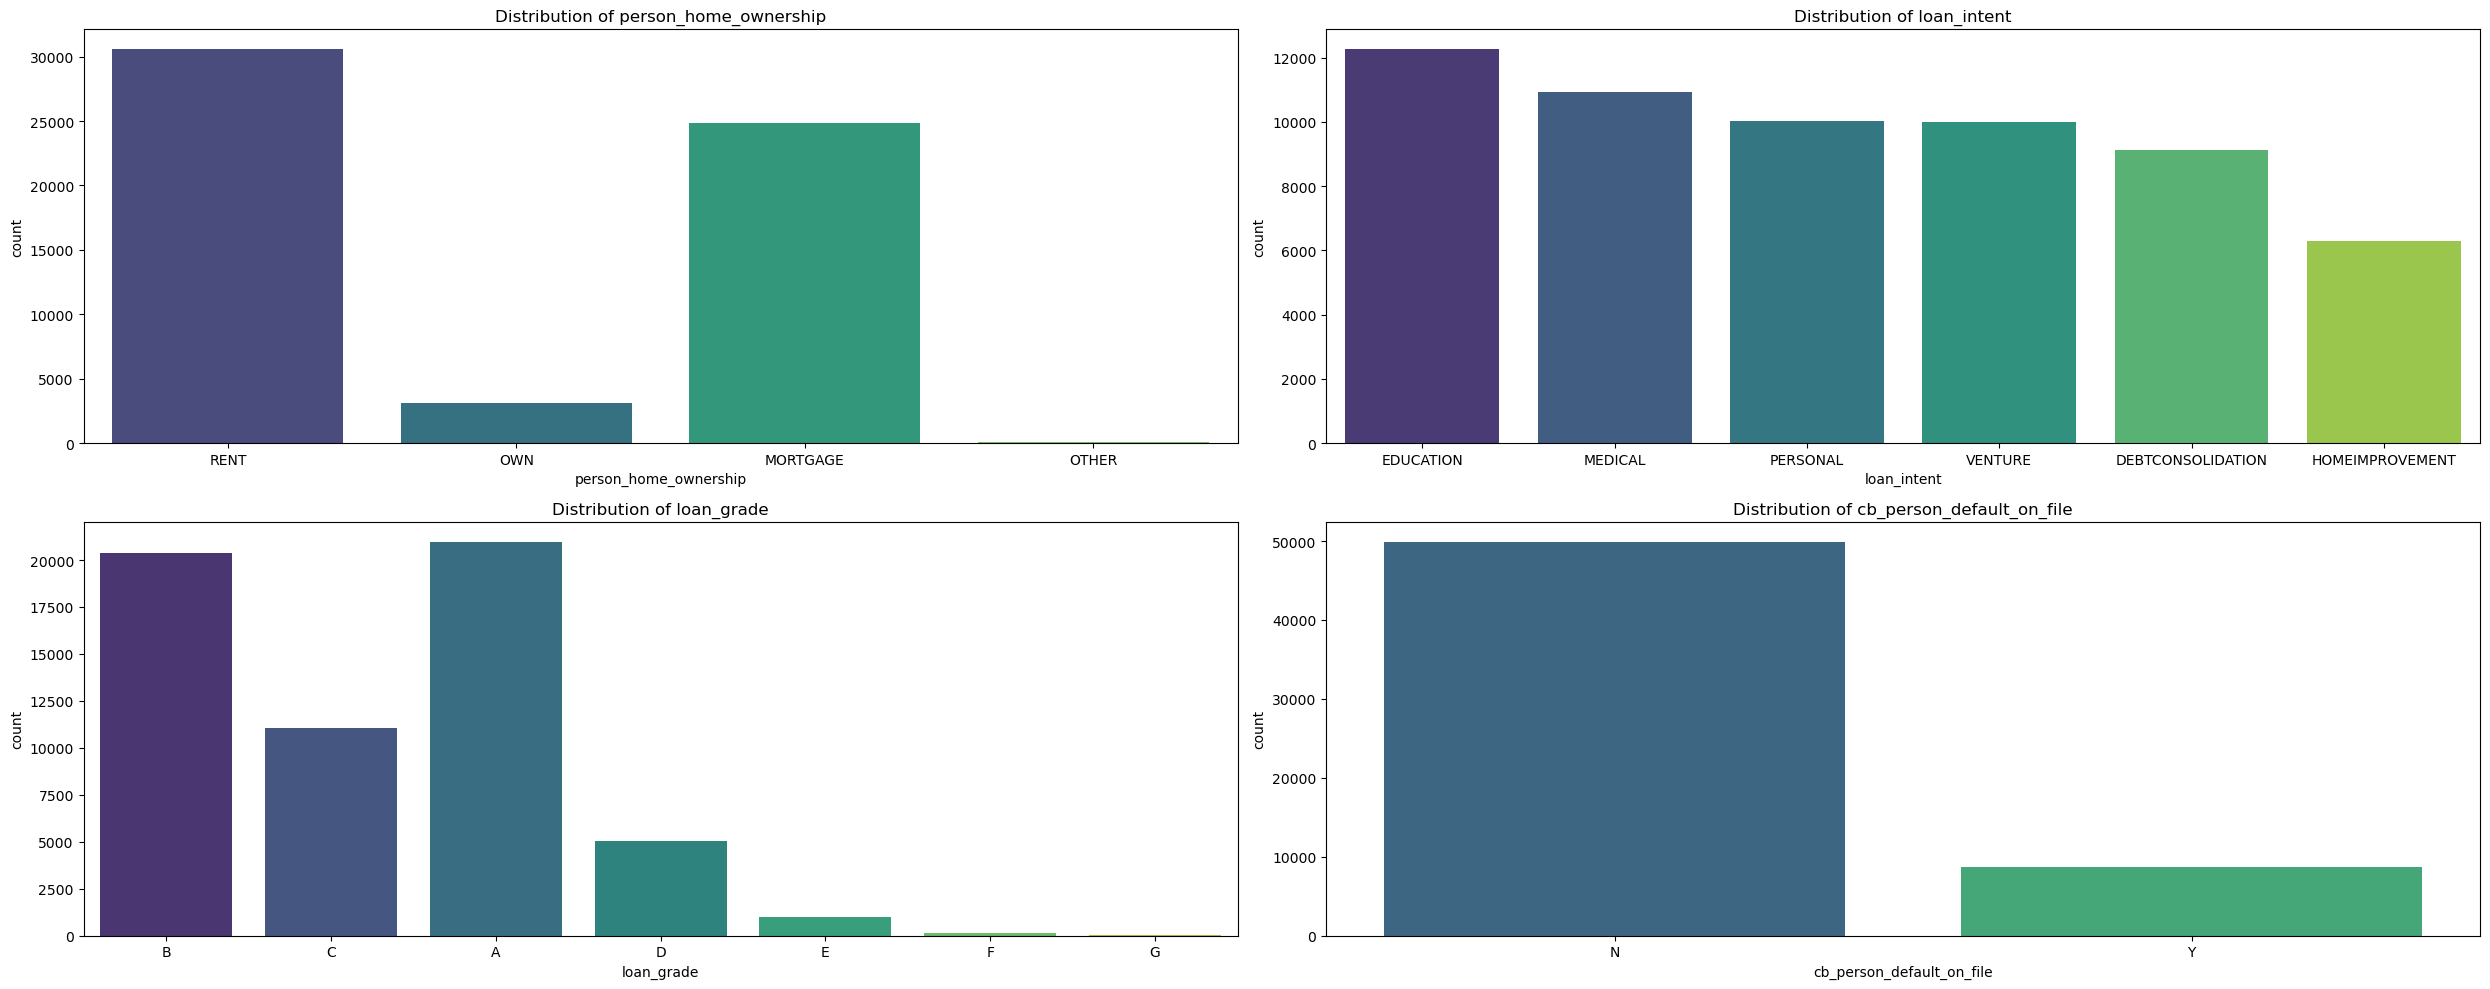

In [133]:
# Create a figure and axes
_, axes = plt.subplots(2, 2, figsize=(25, 10))
axes = axes.flatten()

# Loop through features and plot
for i, feature in enumerate(cat_features):
    sns.countplot(data=df_train, x=feature, hue=feature, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

Nothing too surprising in these graphs as we have seen equivalent graphs from the profile report. These are just here for easier reference. Lets move on to individual feature analysis.

### person_home_ownership
The profile report shows that most applicants rent (52.2%), followed by mortgaging (42.3%), then owning (5.4%) a house. The rest makes up an "other" category with 0.2% of applicants. Let's take a look at how `person_home_ownership` correlates with the numerical features.

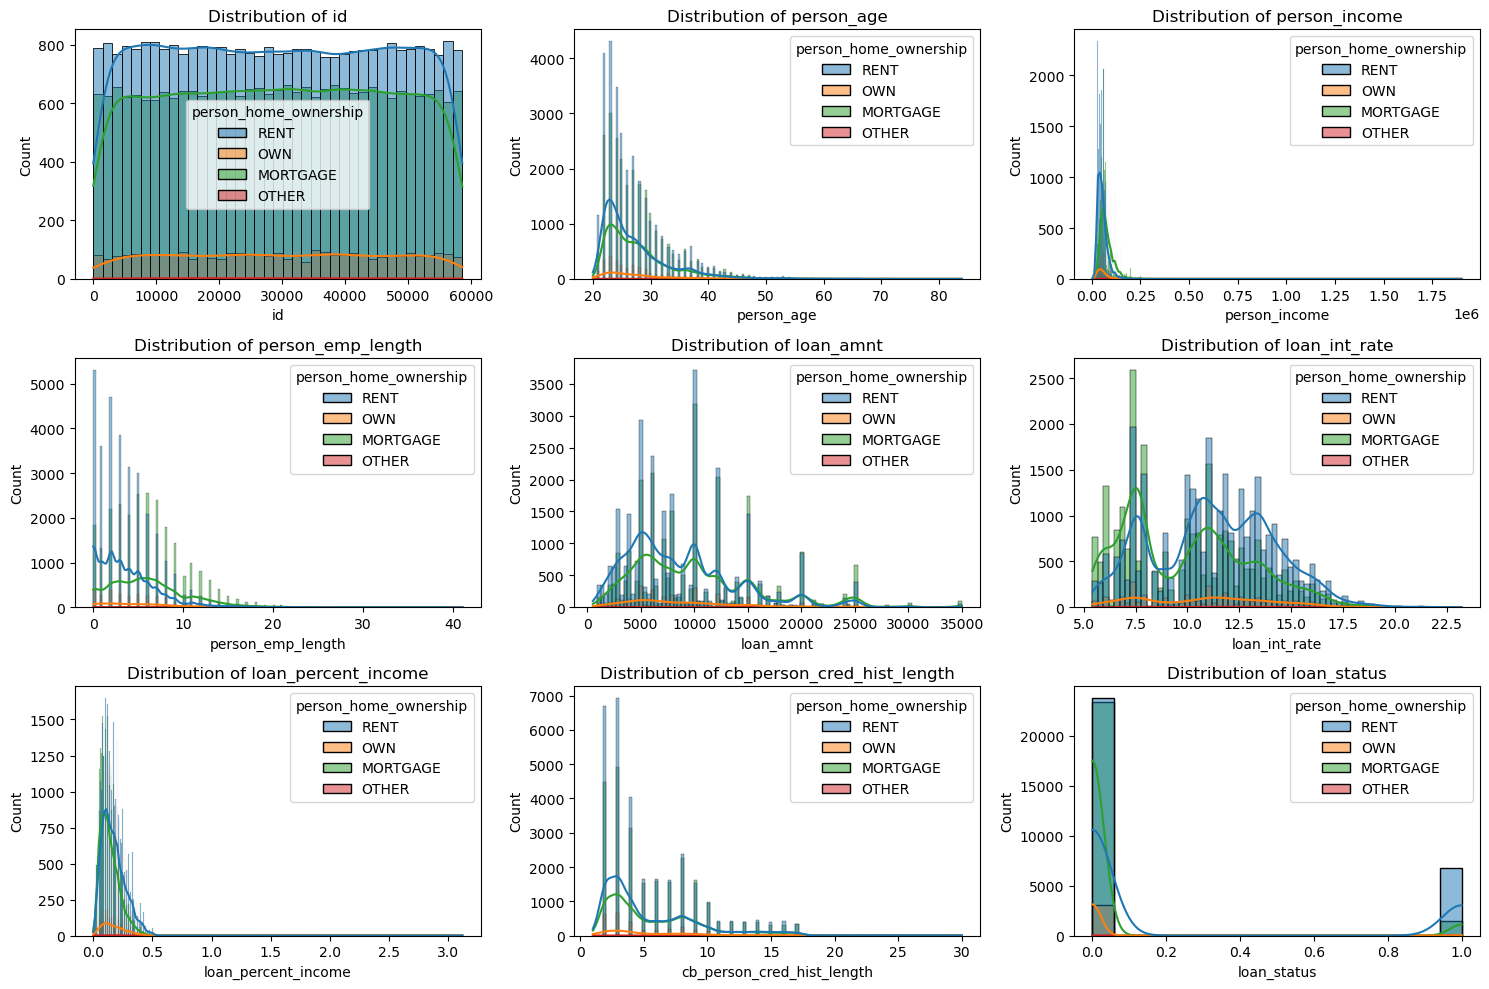

In [ ]:
from typing import List

def plot_against_numerical_features(
            df: pd.DataFrame,
            categorical_feature: str,
            numerical_features: List[str],
            nrows: int,
            ncols: int
        ):
        # Define the number of rows and columns
        rows = nrows
        cols = ncols

        # Create a figure and axes
        _, axes = plt.subplots(rows, cols, figsize=(15, 10))
        axes = axes.flatten()

        # Loop through features and plot
        for i, feature in enumerate(numerical_features[1:]):
            sns.histplot(data=df, x=feature, hue=categorical_feature, kde=True, ax=axes[i])
            axes[i].set_title(f"Distribution of {feature}")

        plt.tight_layout()
        plt.show()

plot_against_numerical_features(
      df=df_train,
      categorical_feature='person_home_ownership',
      numerical_features=numeric_features,
      nrows=3,
      ncols=3
)

As expected, there does not seem to be any strong correlation between `person_home_ownership` and the numerical features. I suspected that we would see some positive correlation between `person_home_ownership` and `person_age` or `person_income` since intuitively older generations tend to have more income and tend to own houses compared to younger generations. Let's investigate the correlations of these features. Since the data is not normal and that one feature is numerical while the other is categorical, we will be using the [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test) to measure correlation and [mutual information](https://en.wikipedia.org/wiki/Mutual_information) to measure dependence.

In [93]:
from scipy.stats import kruskal
from sklearn.feature_selection import mutual_info_regression

def test_non_normal_cat_vs_num(df: pd.DataFrame, cat_feature: str, num_feature: str):
    # Group numerical values by categories
    groups = [
        df[df[cat_feature] == category][num_feature]
        for category in df[cat_feature].unique()
    ]

    # Perform Kruskal-Wallis test
    h_stat, p_value = kruskal(*groups)

    # Encode categorical feature as numerical (automatically handled by MI function)
    cat_feature_encoded = df[cat_feature].astype('category').cat.codes

    # Compute Mutual Information
    mi_score = mutual_info_regression(cat_feature_encoded.values.reshape(-1, 1), df[num_feature])

    print(f"Categorical feature: {cat_feature}")
    print(f"Numerical feature: {num_feature}")

    print(f"Kruskal-Wallis H-statistic: {h_stat:.2f}, P-value: {p_value:.2f}")
    if p_value < 0.05:
        print("→ The p-value is statistically significant (p < 0.05), suggesting that at least one group has a different distribution.")
    else:
        print("→ The p-value is not statistically significant (p ≥ 0.05), meaning the distributions are likely similar across categories.")

    print(f"Mutual Information Score: {mi_score[0]:.2f}")
    # Interpretation of Mutual Information Score
    if mi_score < 0.05:
        print("→ Very weak dependency (MI < 0.05), meaning the categorical feature has almost no impact on the numerical feature.")
    elif mi_score < 0.1:
        print("→ Weak dependency (0.05 ≤ MI < 0.1), indicating a small correlation.")
    elif mi_score < 0.3:
        print("→ Moderate dependency (0.1 ≤ MI < 0.3), meaning there is some influence of the categorical feature on the numerical feature.")
    else:
        print("→ Strong dependency (MI ≥ 0.3), suggesting a strong correlation between the categorical and numerical features.")

    print("\n")

test_non_normal_cat_vs_num(df_train, 'person_home_ownership', 'person_age')
test_non_normal_cat_vs_num(df_train, 'person_home_ownership', 'person_income')


Categorical feature: person_home_ownership
Numerical feature: person_age
Kruskal-Wallis H-statistic: 357.30, P-value: 0.00
→ The p-value is statistically significant (p < 0.05), suggesting that at least one group has a different distribution.
Mutual Information Score: 0.00
→ Very weak dependency (MI < 0.05), meaning the categorical feature has almost no impact on the numerical feature.


Categorical feature: person_home_ownership
Numerical feature: person_income
Kruskal-Wallis H-statistic: 8442.14, P-value: 0.00
→ The p-value is statistically significant (p < 0.05), suggesting that at least one group has a different distribution.
Mutual Information Score: 0.09
→ Weak dependency (0.05 ≤ MI < 0.1), indicating a small correlation.




As we can see from the tests, even though p-values were significant for the Kruskal0-Wallis tests, it is most likely due to the OWN and OTHER groups that have the different disribution. The mutual information scores further supports this as it indicates that there are barely any correlation between `person_home_ownership` on `person_age`or `person_income`. Therefore, `person_home_ownership` is its standalone feature.

### loan_intent
Now, lets carry out the same analysis for `loan_intent`.

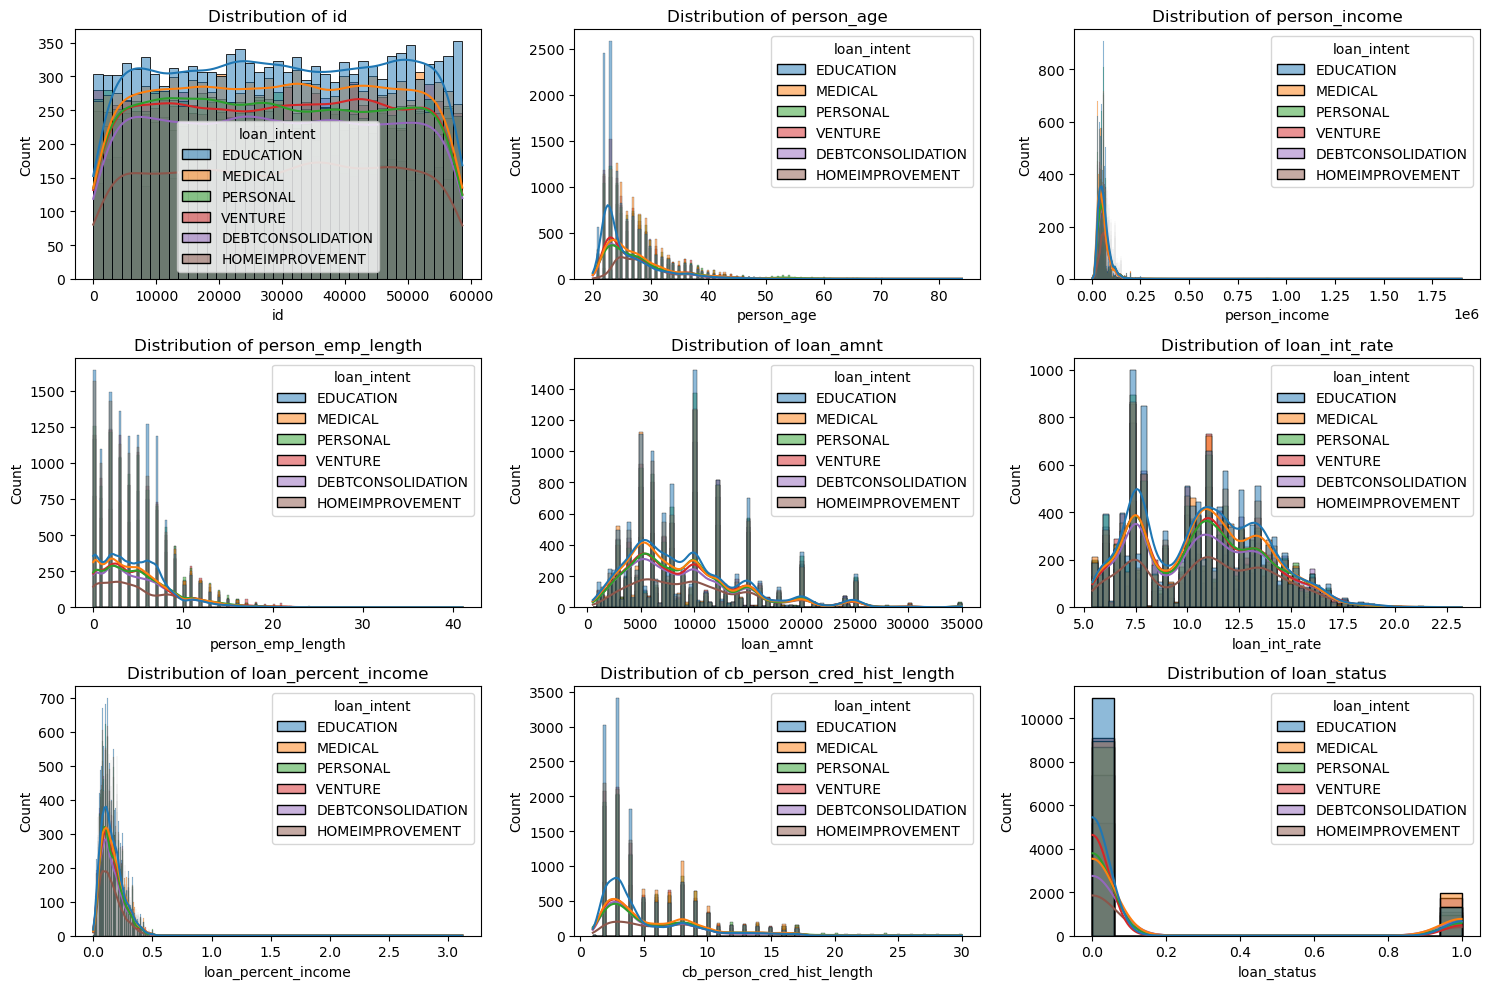

In [97]:
plot_against_numerical_features(
    df=df_train,
    categorical_feature='loan_intent',
    numerical_features=numeric_features,
    nrows=3,
    ncols=3
)

As suspected from the profile report, nothing seems to be standing out from these graphs. That being said, an important thing to investigate is the distribution of `loan_intent` on `loan_status` specifically to see the percentages of loan approvals depending on the intent.

In [108]:
for intent in df_train['loan_intent'].unique():
    num_of_occurrences = df_train[df_train['loan_intent']==intent]
    approved = num_of_occurrences[num_of_occurrences['loan_status']==1]
    denied = num_of_occurrences[num_of_occurrences['loan_status']==0]
    approved_pct = len(approved) / len(num_of_occurrences) * 100
    denied_pct = len(denied) / len(num_of_occurrences) * 100
    print(f"Out of the {len(num_of_occurrences)} {intent} loans:")
    print(f"Approved: {len(approved)} ({approved_pct:.2f}%), Denied: {len(denied)} ({denied_pct:.2f}%)\n")

Out of the 12271 EDUCATION loans:
Approved: 1322 (10.77%), Denied: 10949 (89.23%)

Out of the 10933 MEDICAL loans:
Approved: 1948 (17.82%), Denied: 8985 (82.18%)

Out of the 10016 PERSONAL loans:
Approved: 1330 (13.28%), Denied: 8686 (86.72%)

Out of the 10010 VENTURE loans:
Approved: 929 (9.28%), Denied: 9081 (90.72%)

Out of the 9133 DEBTCONSOLIDATION loans:
Approved: 1729 (18.93%), Denied: 7404 (81.07%)

Out of the 6280 HOMEIMPROVEMENT loans:
Approved: 1091 (17.37%), Denied: 5189 (82.63%)



It seems that the highest approval rate is for DEBTCONSOLIDATION loans while the lowest ones are for EDUCATION loans which is unfortunate. However, it terms of statistical analysis, the differences between the intents are not significantly different so we will leave it at that.

#### loan_grade & cb_person_default_on_file
As seen in the profile report and as we have investigated earlier with `loan_int_rate`, all 3 of these features are highly correlated. Since we have done the analysis with `loan_int_rate`, lets now do the analysis between these two features themselves.

Let's conduct a Chi-Square Test to see just how exactly correlated they are.

In [110]:
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(df_train['loan_grade'], df_train['cb_person_default_on_file'])

# Compute Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Compute Cramer's V
n = df_train.shape[0]
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"Cramer's V: {cramers_v}, P-value: {p}")

Cramer's V: 0.6453385036202027, P-value: 0.0


As expected, the p-value is virtually 0 indicating that the two values are highly correlated and that the two groups have a significant difference. It was also seen earlier than as the loan grade quality decreases (A -> D), the applicant is more likely to default in the past. In fact, according to [Investopedia](https://www.investopedia.com/terms/d/default2.asp#:~:text=Late%20payments%20and%20defaults%20are,you%20to%20recover%20the%20debt.) the past default directly affects the grade of the new loan application.

In terms of our use case, we will need to see if we want to drop one of these features before passing it into the model since they're highly correlated and a causal link is at play.

## Conclusion for Categorical Features EDA
Unlike the numerical features, there were no data manipulation to be done for the categorical features as they all behaved quite fairly. The only thing to look out for are the high correlations between some of the features.